<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=8>
    Image Captioning

In this notebook, we will create and train a neural network to generate captions for images using the [MS-COCO dataset](https://cocodataset.org/#home). Image captioning is a task that requires techniques from both computer vision and natural language processing. The COCO dataset is a large-scale object detection, segmentation, and captioning dataset that will be used to train our model. Our neural network architecture will consist of both convolutional neural networks (CNNs) and recurrent nural networks (RNNs) to automatically generate captions from images. We will be using an Encoder-Decoder architecture that combines the outputs of an image classification CNN (resnet, inception, ... ) and an RNN model (GRU, LSTM) to produce the relevant caption. The accuracy of our model will be evaluated using widely used evaluation metrics in the image captioning field such as BLEU and Perplexity metrics.

To simplify the process, we will use a pre-trained model for the vision part using transfer learning technique. Transfer learning is a popular method in computer vision that allows us to build accurate models in a time-saving way by starting from patterns that have been learned when solving a different problem. A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We can either use the pre-trained model as is or use transfer learning to customize this model to our given task.

## Preliminares

### Install and import required packages

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import nltk
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm
from PIL import Image

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Download the COCO dataset

In [ ]:
# Downloading train2017.zip, annotations_trainval2017.zip , val2017.zip and test2017.zip
os.system('wget http://images.cocodataset.org/annotations/image_info_test2017.zip')
os.system('unzip image_info_test2017.zip')
os.system('rm image_info_test2017.zip')

os.system('wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip')
os.system('unzip annotations_trainval2017.zip')
os.system('rm annotations_trainval2017.zip')

os.system('wget http://images.cocodataset.org/zips/train2017.zip')
os.system('unzip train2017.zip')
os.system('rm train2017.zip')

os.system('wget http://images.cocodataset.org/zips/val2017.zip')
os.system('unzip val2017.zip')
os.system('rm val2017.zip')

0

### Prepare dataset

In [ ]:
import json

# paths of the json files
json_paths = [
    ('/content/annotations/captions_train2017.json', '/content/train_captions.csv'),
    ('/content/annotations/captions_val2017.json', '/content/val_captions.csv'),
    ('/content/annotations/image_info_test2017.json', '/content/test_captions.csv')
  ]

for path in json_paths:
    # Opening the JSON file containing image annotations and load the content into a dictionary
    with open(path[0]) as file:
        annotations = json.load(file)

    if annotations.get('annotations'):
            # Creating a dictionary to map image file names to their corresponding image IDs
        file_name_to_id = {}
        for image in annotations['images']:
            file_name_to_id[image['file_name']] = image['id']
    else:
        file_name_to_id = {}
        for image in annotations['images']:
            file_name_to_id[image['file_name']] = image['coco_url']


    if annotations.get('annotations'):
        # Creating a dictionary to map image IDs to their corresponding captions
        id_to_caption = {}
        for annotation in annotations['annotations']:
            id_to_caption[annotation['image_id']] = annotation['caption']
        # Mapping the id_to_caption dictionary to the file_name_to_id dictionary
        for key in file_name_to_id.keys():
            file_name_to_id[key] = id_to_caption[file_name_to_id[key]]
        # Using the Pandas library to create a new dataframe with columns named 'image' and 'caption'
        data_frame = pd.DataFrame(columns=['image','caption'])

    data_frame = pd.DataFrame(columns=['image','caption'])
    data_frame['image'] = file_name_to_id.keys()
    data_frame['caption'] = file_name_to_id.values()
    # Writing the dataframe to a CSV file
    data_frame.to_csv(path[1], index=False)

Next, we load the saved data frames and update the `image` column with the correct addresses of the image files. Since there is no caption for the test set, we utilized the download URL from COCO and placed it in the caption column. This will use in the Dataset class in the next section.

In [ ]:
# Loading the training captions dataframe
train_df = pd.read_csv('train_captions.csv')

# Loading the validation captions dataframe
val_df = pd.read_csv('val_captions.csv')

# Loading the test captions dataframe
test_df = pd.read_csv('test_captions.csv')

# Updating the 'image' column in the training dataframe with the correct addresses of the image files
train_df['image'] = train_df['image'].apply(lambda x: '/content/train2017/' + x)

# Updating the 'image' column in the validation dataframe with the correct addresses of the image files
val_df['image'] = val_df['image'].apply(lambda x: '/content/val2017/' + x)

# Working with the updated training dataframe
train_df

image  \
0       /content/train2017/000000391895.jpg   
1       /content/train2017/000000522418.jpg   
2       /content/train2017/000000184613.jpg   
3       /content/train2017/000000318219.jpg   
4       /content/train2017/000000554625.jpg   
...                                     ...   
118282  /content/train2017/000000444010.jpg   
118283  /content/train2017/000000565004.jpg   
118284  /content/train2017/000000516168.jpg   
118285  /content/train2017/000000547503.jpg   
118286  /content/train2017/000000475546.jpg   

                                                  caption  
0       A man in a red shirt and a red hat is on a mot...  
1       A woman marking a cake with the back of a chef...  
2       A boy holding an umbrella while standing next ...  
3       a young kid with head phones on using a computer   
4       A small child wearing headphones plays on the ...  
...                                                   ...  
118282   A jovial older couple and a young woman enjoy...  
118283           A wine glass being filled with red wine.  
118284  A man is sitting at a table with papers and wi...  
118285  Old couple is sitting at the bar with wine gla...  
118286         Three women and a man are sitting at a bar  

[118287 rows x 2 columns]

In [ ]:
test_df

image                                            caption
0      000000466319.jpg  http://images.cocodataset.org/test2017/0000004...
1      000000523573.jpg  http://images.cocodataset.org/test2017/0000005...
2      000000308929.jpg  http://images.cocodataset.org/test2017/0000003...
3      000000057540.jpg  http://images.cocodataset.org/test2017/0000000...
4      000000579853.jpg  http://images.cocodataset.org/test2017/0000005...
...                 ...                                                ...
40665  000000361178.jpg  http://images.cocodataset.org/test2017/0000003...
40666  000000208495.jpg  http://images.cocodataset.org/test2017/0000002...
40667  000000204154.jpg  http://images.cocodataset.org/test2017/0000002...
40668  000000206086.jpg  http://images.cocodataset.org/test2017/0000002...
40669  000000312963.jpg  http://images.cocodataset.org/test2017/0000003...

[40670 rows x 2 columns]

### Create Vocabulary
In NLP tasks, we need to have a vocabulary that holds all available tokens of the language or dataset, and this vocabulary is used to convert words to integer IDs and vice versa. The below cell creates a vocabulary class that is used to creates a vocabulary for a text corpus, It also saves the vocabulary in a pickle file for future usage.

In [ ]:
import pickle
from collections import Counter
from nltk.tokenize import word_tokenize

class Vocabulary(object):
    def __init__(self, texts, unk_cutoff=3, vocab_file='./vocabulary.pkl',
                 start_token="<START>", end_token="<END>",
                 unk_token="<UNK>", pad_token="<PAD>"):
        """
        Initializes a Vocabulary object.

        Parameters:
            texts (list): A list of texts or captions used to build the vocabulary.
            unk_cutoff (int, optional): The minimum count threshold for a word to be included in the vocabulary. Defaults to 3.
            vocab_file (str, optional): The file path to save or load the vocabulary. Defaults to './vocabulary.pkl'.
            start_token (str, optional): The token to represent the start of a sequence. Defaults to "<START>".
            end_token (str, optional): The token to represent the end of a sequence. Defaults to "<END>".
            unk_token (str, optional): The token to represent unknown words. Defaults to "<UNK>".
            pad_token (str, optional): The token to represent padding. Defaults to "<PAD>".
        """
        self.texts = texts
        self.unk_cutoff = unk_cutoff
        self.vocab_file = vocab_file
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self._get_vocab()

    def _get_vocab(self):
        # Loading vocabulary if it already exists
        if os.path.exists(self.vocab_file):
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print(f'Vocabulary successfully loaded from {self.vocab_file} file!')
        else:
            self._build_vocab()
            # Saving the vocabulary to a file
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def _build_vocab(self):
        # Initializing the vocabulary
        self._init_vocab()
        # Adding special tokens
        self._add_word(self.pad_token)
        self._add_word(self.start_token)
        self._add_word(self.end_token)
        self._add_word(self.unk_token)
        # Adding words from the texts
        self._add_captions()

    def _init_vocab(self):
        # Initializing word-to-index and index-to-word mappings
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def _add_word(self, word):
        # Adding a word to the vocabulary if it doesn't exist
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def _add_captions(self):
        counter = Counter()
        for i, caption in enumerate(self.texts):
            # Tokenizing captions into words
            tokens = word_tokenize(caption.lower())
            # Updating word counts
            counter.update(tokens)

            if i % 10000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(self.texts)))

        # Adding words to the vocabulary based on their counts
        words = [word for word, cnt in counter.items() if cnt >= self.unk_cutoff]
        for i, word in enumerate(words):
            self._add_word(word)

    def decode(self, preds):
        # Decoding a sequence of indices into text
        text = ''
        for idx in preds:
            # Ignoring start, end, and pad tokens
            if idx <= 2:
                continue
            text += f'{self.idx2word[idx]} '
        return text.strip()

    def __call__(self, word):
        # Getting the index of a word in the vocabulary
        if word not in self.word2idx:
            return self.word2idx[self.unk_token]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

We utilize all captions in the train and validation sets to create our vocabulary.

In [ ]:
captions = pd.concat([train_df['caption'] , val_df['caption']]).to_list()
vocab = Vocabulary(captions)

[0/123287] Tokenizing captions...
[10000/123287] Tokenizing captions...
[20000/123287] Tokenizing captions...
[30000/123287] Tokenizing captions...
[40000/123287] Tokenizing captions...
[50000/123287] Tokenizing captions...
[60000/123287] Tokenizing captions...
[70000/123287] Tokenizing captions...
[80000/123287] Tokenizing captions...
[90000/123287] Tokenizing captions...
[100000/123287] Tokenizing captions...
[110000/123287] Tokenizing captions...
[120000/123287] Tokenizing captions...


### Create Dataset Class

Since we want to utilize the COCO dataset for our image captioning task, we need to create a custom dataset that reads each image from a file along with its corresponding caption. We then apply transformations to the image and tokenize the caption using the created vocabulary.

In [ ]:
import requests
from io import BytesIO
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class COCODataset(Dataset):
    def __init__(self, df, vocab, mode='train'):
        """
        Initializes the COCODataset.

        Args:
            df (DataFrame): DataFrame containing image paths and captions.
            vocab (object): Vocabulary object.
            mode (str): Mode indicating the dataset type ('train', 'test', or 'validation').
        """
        self.vocab = vocab
        self.image_paths = df['image'].to_list()
        self.captions = df['caption'].to_list()
        self.mode = mode

        # Setting data transformation pipeline based on the mode
        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
                    std=torch.tensor([0.26862954, 0.26130258, 0.27577711])
                )
            ])
        elif self.mode in ["test", "validation"]:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
                    std=torch.tensor([0.26862954, 0.26130258, 0.27577711])
                )
            ])

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.

        Args:
            idx (int): Index of the item.

        Returns:
            dict: Dictionary containing the image and caption (for train/validation) or image and original image (for test).
        """
        if self.mode in ['train', 'validation']:
            caption = list()
            tokens = word_tokenize(self.captions[idx].lower())

            # Prepending start token, append end token, and convert tokens to vocabulary indices
            caption.append(self.vocab(self.vocab.start_token))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_token))

            # Transforming the image and return the image and caption
            image = self.transform(Image.open(self.image_paths[idx]).convert('RGB'))

            return {
                'image': image,
                'caption': torch.tensor(caption).long()
            }
        else:
            # For test mode, retrieving the image from a URL and return the transformed image and original image
            response = requests.get(self.captions[idx])
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return {
                'image': self.transform(img),
                'original': img
            }

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.image_paths)

Now, we can create our dataset objects by passing each dataframe to the COCODataset class along with its corresponding mode.

In [ ]:
train_dataset = COCODataset(train_df, vocab=vocab, mode='train')
val_dataset = COCODataset(val_df, vocab=vocab, mode='validation')
test_dataset = COCODataset(test_df, vocab=vocab, mode='test')

### Helper functions

In the last part of this section, we create several helper functions to visualize the data. Additionally, we display some sample data to enhance our understanding of the task at hand.

In [ ]:
import matplotlib.pyplot as plt

def show_sample(img, text, cols=3):
    """
    Function to display a sample image with its corresponding text.

    Args:
        img (list or ndarray): The image(s) to display.
        text (list or str): The text(s) to display.
        cols (int): Number of columns to arrange the images.

    Returns:
        None
    """
    if not isinstance(img, list):
        # Displaying a single image
        plt.imshow(img)
        plt.axis('off')
        plt.text(0.5, -0.1, text, size=12, ha='center', transform=plt.gca().transAxes)
    else:
        # Displaying multiple images
        rows = int(len(img) / cols) if len(img) % cols == 0 else int(len(img) / cols) + 1
        fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

        if rows == 1:
            for idx in range(cols):
                axs[idx].axis('off')
                if idx < len(img):
                    axs[idx].imshow(img[idx])
                    axs[idx].text(0.5, -0.1, text[idx], size=10, ha='center', transform=axs[idx].transAxes)
        else:
            for i in range(rows):
                for j in range(cols):
                    idx = i * cols + j
                    axs[i][j].axis('off')
                    if idx < len(img):
                        axs[i][j].imshow(img[idx])
                        axs[i][j].text(0.5, -0.1, text[idx], size=10, ha='center', transform=axs[i][j].transAxes)
    plt.show()

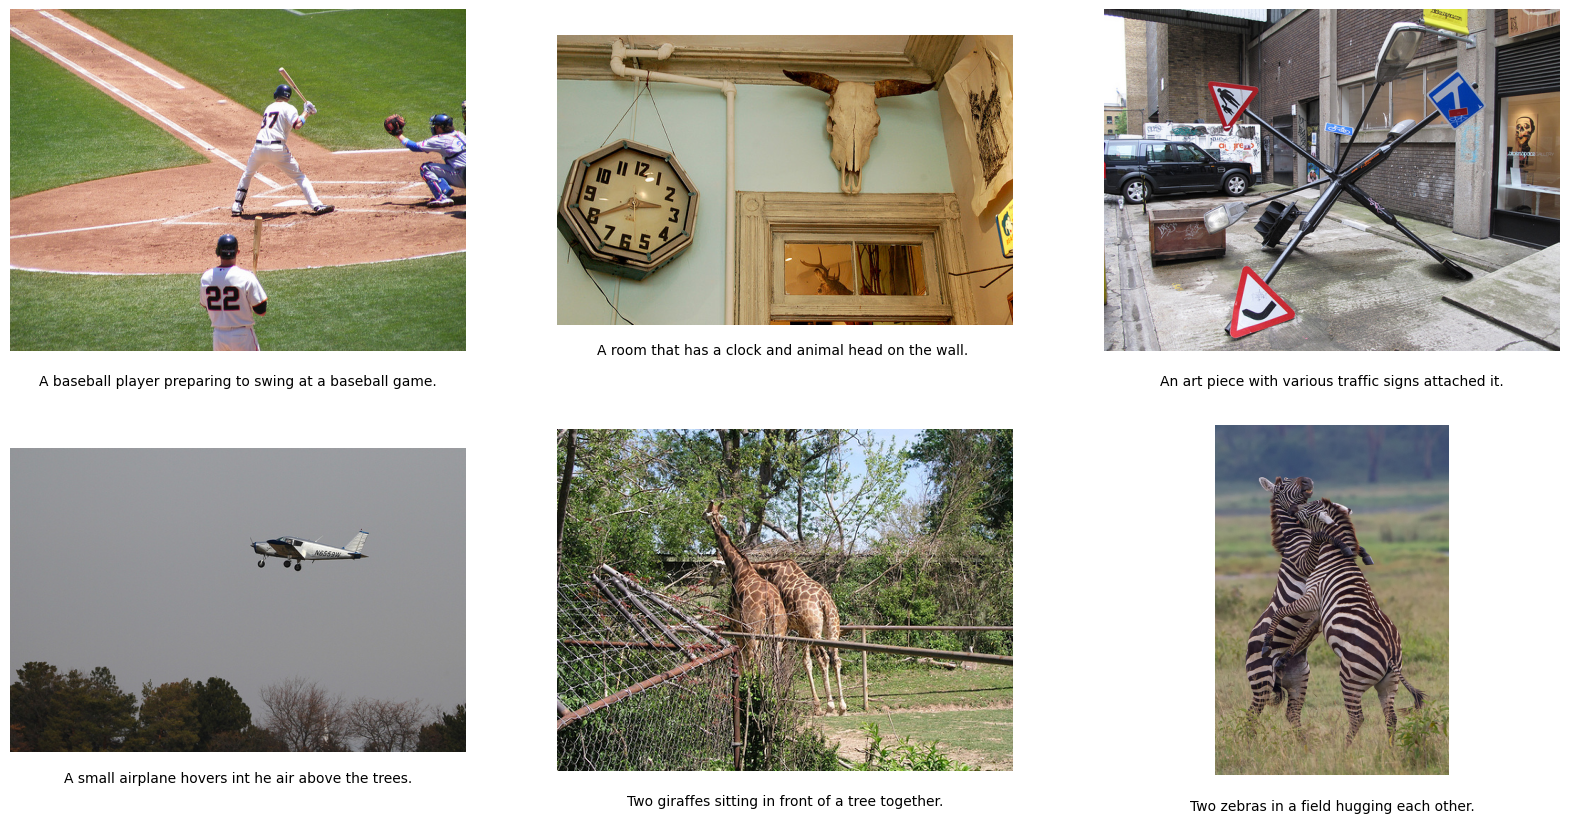

In [ ]:
# showing some sample from the train dataset
images_s, text_s = [], []
for i in range(6):
  idx = np.random.randint(0, len(train_df))
  image = Image.open(train_df.image[idx])
  images_s.append(image)
  text_s.append(train_df.caption[idx])

show_sample(images_s, text_s)

Here, we test the functionality of our written codes. We evaluate the token encoder and decoder by comparing the results with the actual captions and their corresponding images.

Real: A woman marking a cake with the back of a chef's knife. 
encoded: tensor([ 1,  4, 17, 18,  4, 19, 20, 21, 22, 23,  4, 24, 25, 26, 16,  2])
decoded: a woman marking a cake with the back of a chef 's knife .


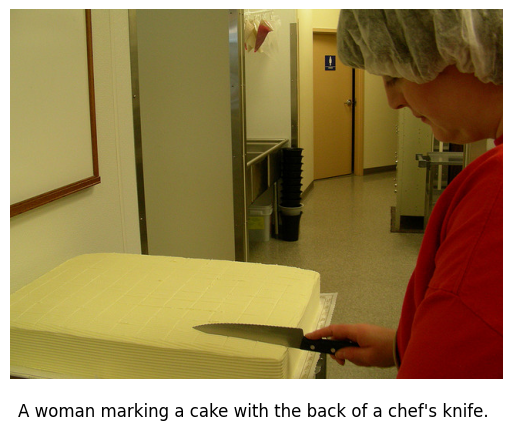

In [ ]:
idx = 1
image = Image.open(train_df.image[idx])
caption = train_df.caption[idx]
encoded = train_dataset[idx]['caption']
decoded = vocab.decode(encoded.tolist())
print(f'Real: {caption}')
print(f'encoded: {encoded}')
print(f'decoded: {decoded}')

show_sample(image, caption)


## Model and Acrchiture

In this section, we will create our encoder-decoder model for the task at hand. The encoder-decoder model for image captioning consists of two main components: an encoder and a decoder.

* **Encoder:**
    The encoder processes the input image and encodes it into a fixed-length vector representation, often called the "image feature vector" or "image embedding." This is typically achieved using a convolutional neural network (CNN), such as VGG or ResNet. The CNN takes the raw image as input and applies a series of convolutional and pooling layers to extract meaningful visual features. The output of the encoder is a condensed representation of the image, capturing its salient features.

* **Decoder:**
    The decoder takes the image embedding generated by the encoder and generates a descriptive caption for the image. It is usually implemented using a recurrent neural network (RNN), such as a long short-term memory (LSTM) or a gated recurrent unit (GRU). The decoder RNN can receives the image embedding as its initial hidden state or feature vector as input and generates words one at a time. At each time step, the decoder predicts the next word in the caption based on its previous hidden state and the previously generated words. This process continues until an end-of-sentence token is generated or a predefined maximum caption length is reached.

During training, the model is provided with pairs of images and their corresponding captions. The encoder processes the images, and the decoder is trained to generate captions that match the ground truth captions. This training is typically done using techniques like teacher forcing, where the model is fed the correct previous word as input during training.

At inference time, the encoder-decoder model is used to generate captions for new images. The encoder processes the image to obtain the image embedding, and the decoder generates the caption word by word based on the image embedding and its previous predictions.

We will provide more implementation details in each subsequent parts.


### Encoder

In the encoder model, we will utilize transfer learning techniques by employing a pretrained model for a classification task. We will remove the classification head of the pretrained model and introduce a new representation head that condenses the feature map of the CNN network. Additionally, we will freeze all layers of the CNN model except for the added representation head.

Useful links:

* [ Transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


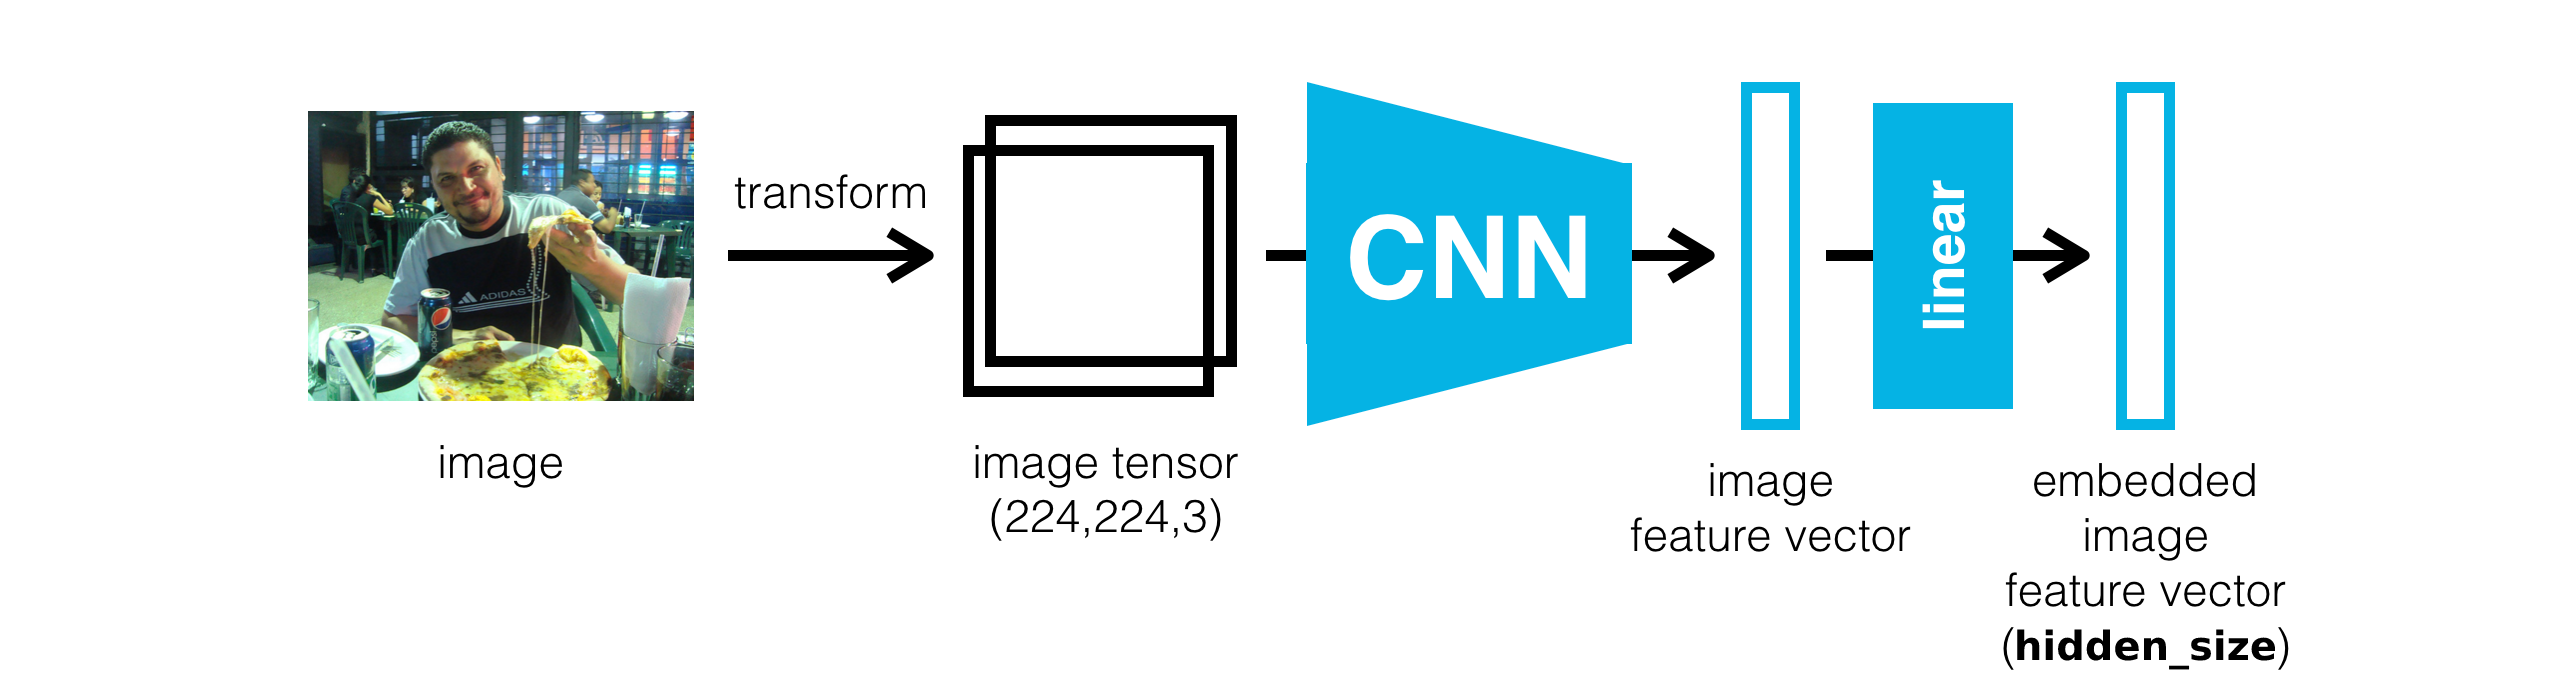

In [ ]:
class Encoder(nn.Module):
    """
    Encoder model that utilizes transfer learning.
    """

    def __init__(self, embed_size):
        """
        Initializes the Encoder class.

        Args:
            embed_size (int): The desired size of the image embedding.

        """
        super(Encoder, self).__init__()

        # Loading a pretrained model
        net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Freezing all the parameters in the net model
        for p in net.parameters():
            p.requires_grad = False

        # Extracting the feature extraction layers from the net model
        modules = list(net.children())[:-1]

        # Creating a sequential module using the feature extraction layers
        self.net = nn.Sequential(*modules)

        # Linear layer to condense the feature map into the desired embedding size
        self.embed = nn.Linear(net.fc.in_features, embed_size)

    def forward(self, images):
        """
        Forward propagation through the encoder.

        Args:
            images: Input images to be encoded.

        Returns:
            features: Encoded image features.
        """
        features = self.net(images)
        features = torch.flatten(features, 1)
        features = self.embed(features)
        return features

### Decoder

In the encoder model, we feed the encoded features from the encoder as well as the encoded captions to the model. The feature vector from the encoder can be employed in different ways. One method is to use it as the initial hidden state, while another method involves concatenating the feature vector with the input embedding vector to generate subsequent words of the sentence.

Our architecture is illustrated in the diagram below.

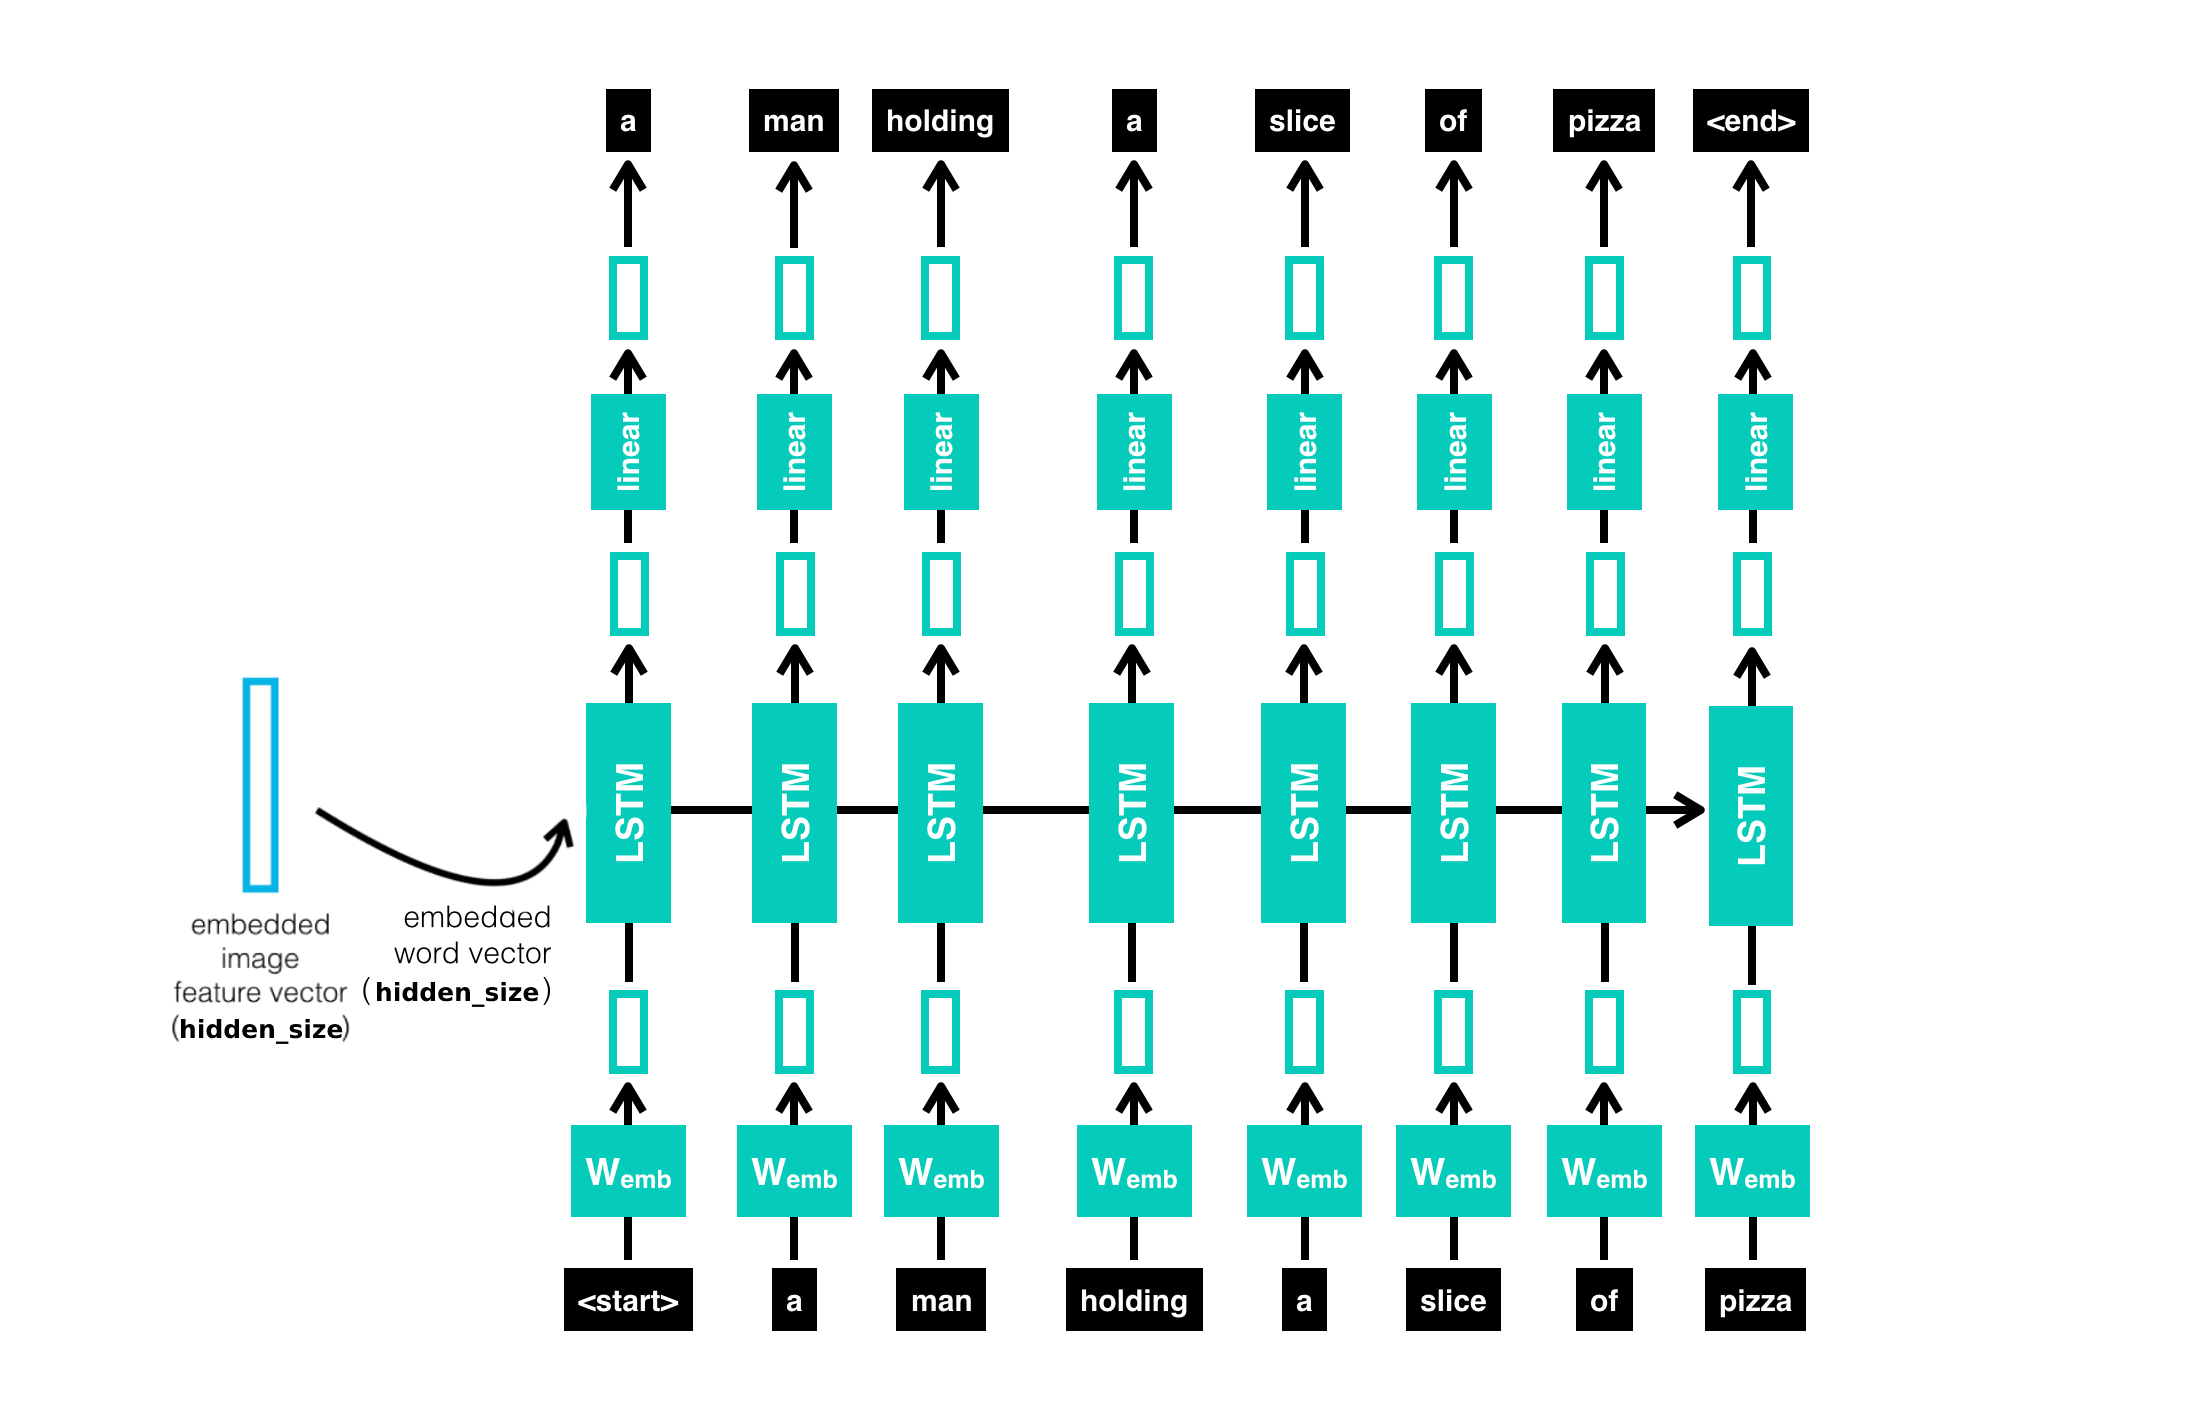

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    """
    Decoder module for generating captions based on image features.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        """
        Initializes the Decoder module.

        Args:
            embed_size (int): Size of the word embeddings.
            hidden_size (int): Size of the hidden state of the LSTM.
            vocab_size (int): Size of the vocabulary.
            num_layers (int, optional): Number of LSTM layers. Defaults to 2.
        """
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.h0 = nn.Linear(embed_size, hidden_size)
        self.c0 = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        """
        Performs the forward pass of the Decoder module.

        Args:
            features (torch.Tensor): Image features.
            captions (torch.Tensor): Caption inputs.

        Returns:
            torch.Tensor: Caption outputs.
        """
        captions = captions[:, :-1]
        hidden = self.init_hidden(features)
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_output, _ = self.lstm(embeddings, hidden)
        outputs = self.linear(lstm_output)

        return outputs

    def generate(self, inputs, max_len):
        """
        Generates captions based on the given inputs.

        Args:
            inputs (torch.Tensor): Input tensor for caption generation.
            max_len (int): Maximum length of the generated caption.

        Returns:
            list: List of generated caption indices.
        """
        outputs = []
        states = None

        states = self.init_hidden(inputs)
        inputs = inputs.unsqueeze(1)
        length = 0

        while (length <= max_len):
          output, states = self.lstm(inputs, states)
          output = self.linear(output)
          pred = output.squeeze().argmax()
          outputs.append(pred.item())
          if (pred == 2):
                break
          inputs = self.embed(pred)
          inputs = inputs.reshape(1, 1, -1)
          length += 1

        return outputs

    def init_hidden(self, features):
        """
        Initializes the hidden state of the LSTM layer with the image features.

        Args:
            features (torch.Tensor): Image features.

        Returns:
            tuple: Initial hidden state of the LSTM layer.
        """
        hidden = None
        h = self.h0(features)
        c = self.c0(features)
        hidden = (h.expand(self.num_layers, -1, -1).contiguous(), c.expand(self.num_layers, -1, -1).contiguous())
        return hidden


### Encoder-Decoder (Image Captioner)

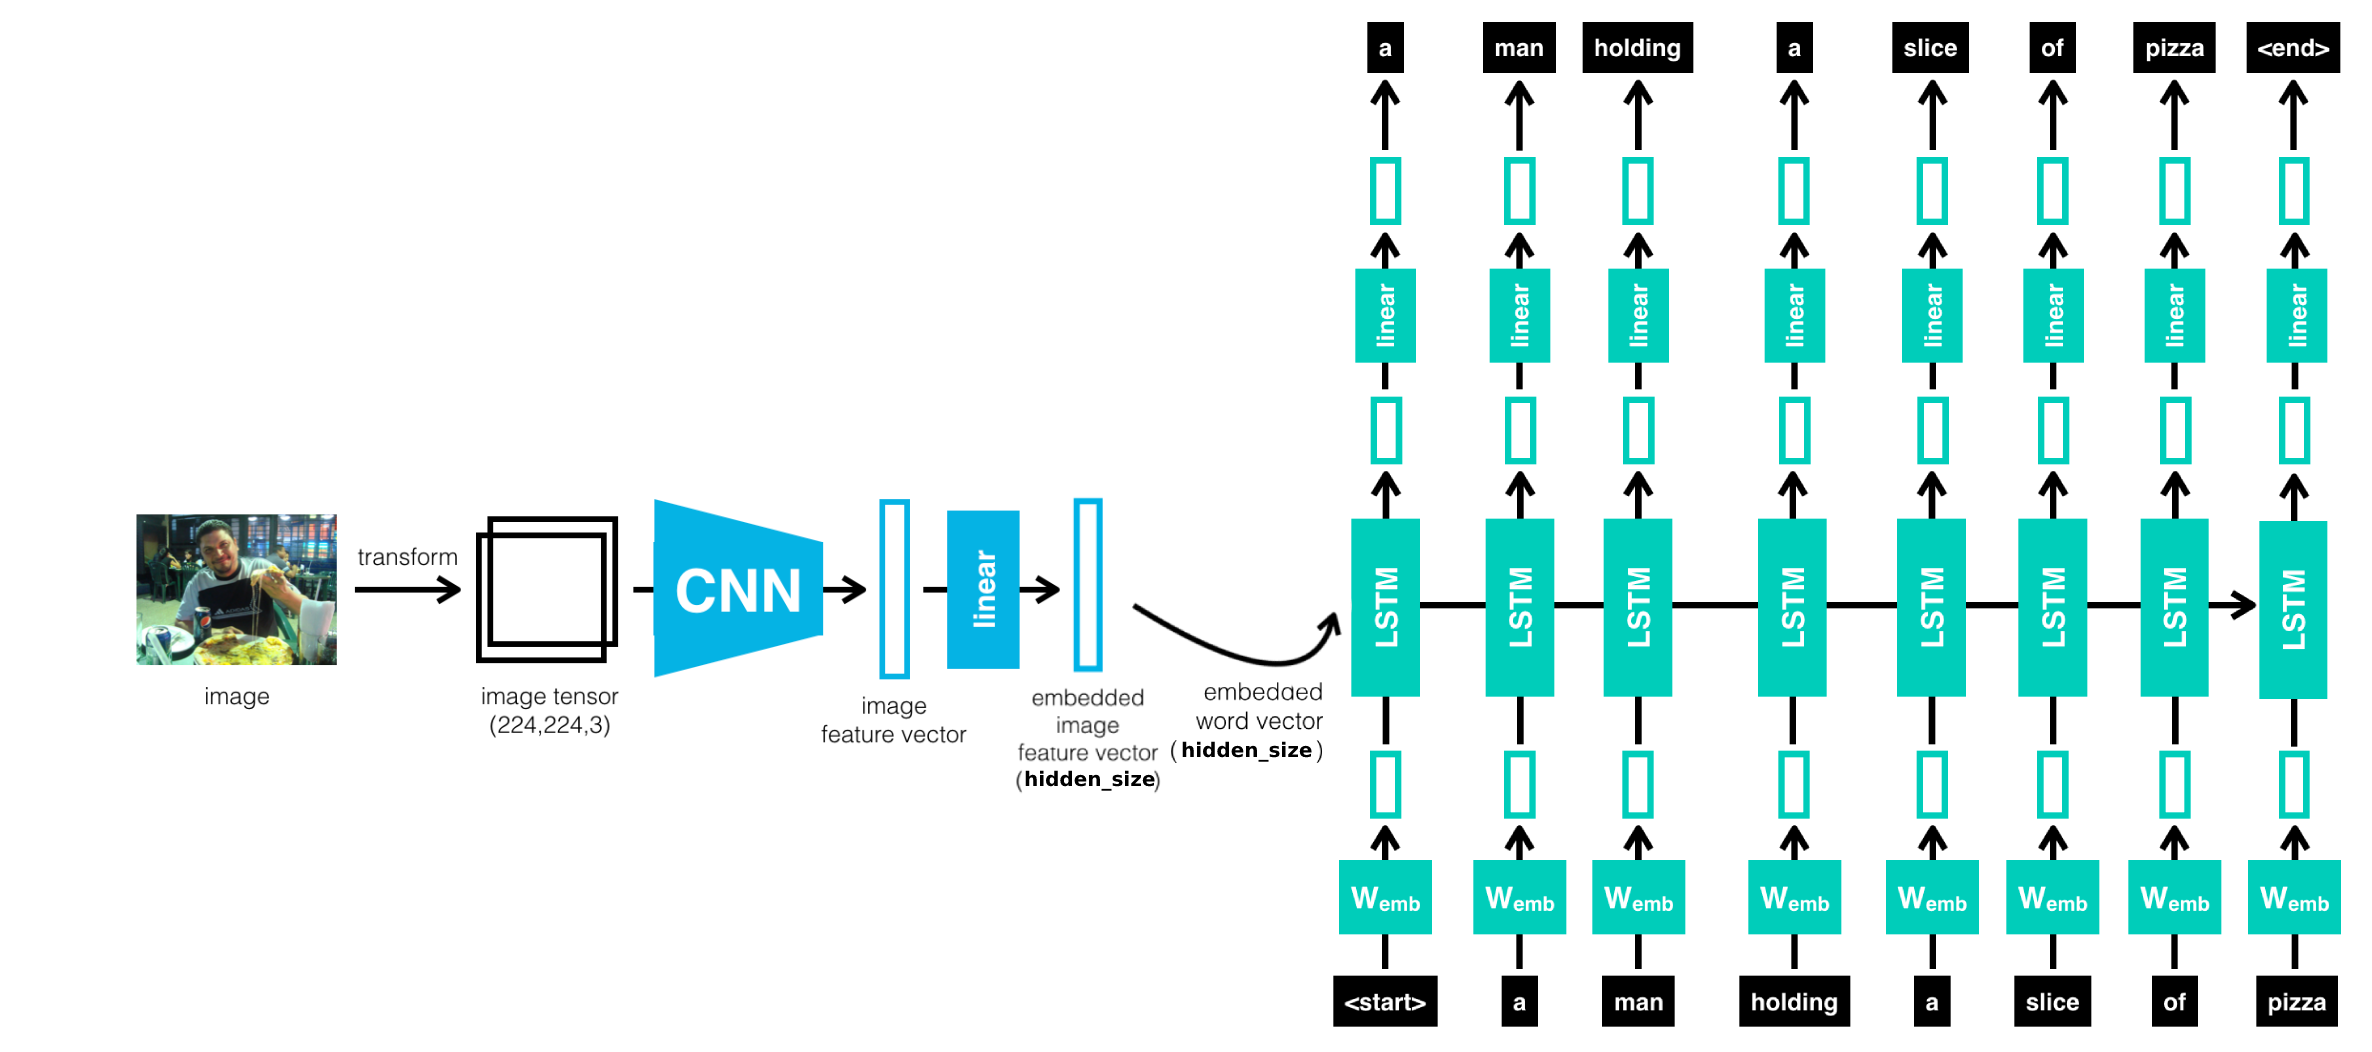

In [ ]:
class ImageCaptioner(nn.Module):
    """
    Image Captioning model that combines an Encoder and a Decoder.
    """

    def __init__(self, embed_size, hidden_size, vocab_size):
        """
        Initializes the ImageCaptioner model.

        Args:
            embed_size (int): Size of the image embedding.
            hidden_size (int): Size of the hidden state in the decoder.
            vocab_size (int): Size of the vocabulary.
        """
        super(ImageCaptioner, self).__init__()
        self.encoder = Encoder(embed_size).to(device)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

    def forward(self, images, captions):
        """
        Forward propagation through the ImageCaptioner model.

        Args:
            images (tensor): Batch of input images.
            captions (tensor): Batch of input captions.

        Returns:
            output (tensor): Output from the decoder model.
        """
        features = self.encoder(images)
        output = self.decoder(features, captions)
        return output

    def predict(self, image, max_len=20):
        """
        Generates a caption for a single input image.

        Args:
            image (tensor): Single input image.
            max_len (int): Maximum length of the generated caption.

        Returns:
            decoded_output (str): Decoded caption.
        """
        image_embedding = self.encoder(image)
        output = self.decoder.generate(image_embedding, max_len)
        decoded_output = vocab.decode(output)

        return decoded_output

## Train and Validation

### Hyperparameter


Below, we will define the hyperparameters for our model. Here are the explanations for each parameter:

- `learning_rate`: The learning rate used for the optimizer to update the model parameters during training.
- `batch_size`: The number of samples to be processed in each training batch.
- `embed_size`: The size of the image embedding vector.
- `hidden_size`: The size of the hidden state in the decoder model.
- `num_epochs`: The total number of training epochs to run.
- `val_every`: Determines how often the model's performance will be evaluated on the validation set during training.
- `print_every`: Controls the frequency at which the training progress is printed, typically after processing a certain number of batches.
- `vocab_size`: The size of the vocabulary, which is the number of unique words in the dataset.
- `device`: The device to be used for training and inference. It is set to use the GPU ("cuda") if available, otherwise it will use the CPU ("cpu").

In [ ]:
learning_rate = 1e-3
batch_size = 128
embed_size = 256
hidden_size = 512
num_epochs = 3
val_every = 500
print_every = 100
vocab_size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Loaders



In this part, we will create the data loaders for the training and validation datasets. Since the sentences in the dataset have variable lengths, we need to pad them before passing them to the model.

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    Collate function used in the data loader to process a batch of samples.

    Args:
        batch (list): List of samples in a batch.

    Returns:
        images (tensor): Stacked tensor of image samples.
        captions (tensor): Padded tensor of caption sequences.
    """
    images = torch.stack([item['image'] for item in batch])
    captions = [item['caption'] for item in batch]
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab('<PAD>'))
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

### Loss Function

In order to effectively guide and train our model, it is necessary to define a loss function that takes target captions and generated captions from the decoder model as input and calculates the loss. This loss calculation will be implemented in the `compute_loss` function. PyTorch provides pre-defined loss functions such as CrossEntropyLoss that can be used for this purpose. However, it is crucial to exclude the added `<PAD>` tokens before computing the loss, as these tokens are not part of the true captions, Including them in the loss calculation may potentially diminish the accuracy of the model.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=0)

def compute_loss(preds, target):
    """
    Compute the loss using the some loss function.

    Args:
        preds (tensor): Predicted logits from the model.
        target (tensor): Target labels.

    Returns:
        loss (tensor): Computed loss.
    """
    #### handling pads with ignore_index in criterion
    preds = preds.reshape(-1, vocab_size)
    target = target.reshape(-1)
    loss = criterion(preds, target)
    return loss

### Evaluation Metrics

In this section, we will define metrics that provide an indication of our model's accuracy in generating captions. Here, we introduce the `compute_metrics` function, which takes target captions and generated captions as inputs and returns a dictionary object with keys `bleu` and `perplexity`. These keys represent the BLEU score and perplexity metrics, respectively.

Useful links:
* [Evaluation of text generation models](https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1)
* [blue score](https://torchmetrics.readthedocs.io/en/stable/text/bleu_score.html)
* [perplexity](https://torchmetrics.readthedocs.io/en/stable/text/perplexity.html)


In [ ]:
from torchmetrics import BLEUScore, Perplexity

perp = Perplexity(ignore_index=vocab('<PAD>')).to(device)
bleu = BLEUScore().to(device)

def compute_metrics(preds, target):
    """
    Compute evaluation metrics including perplexity.

    Args:
        preds (tensor): Predicted logits from the model.
        target (tensor): Target labels.

    Returns:
        result (dict): Dictionary containing computed evaluation metrics.
    """
    result = {}
    result['perplexity'] = perp(preds, target).item()
    decoded_pred = [vocab.decode([j.argmax().item() for j in i]) for i in preds]
    decoded_target = [[vocab.decode(i.tolist())] for i in target]
    result['bleu'] = bleu(decoded_pred, decoded_target).item()
    return result


### Create model and optimizer

In [ ]:
from torch import optim

model = ImageCaptioner(embed_size, hidden_size, vocab_size)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 316MB/s]


### Train Loop

In [ ]:
train_loss = []
val_loss = []
tmp_loss = []

model.train()

# tqdm is used to display progress bars
bar = tqdm(desc="Steps", total=len(train_loader) * num_epochs)
step = 0

for epoch in range(num_epochs):
    for images, captions in train_loader:
        bar.update()
        bar.set_postfix({'Epoch': f'{epoch+1}/{num_epochs}'})
        step += 1

        images, captions = images.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs = model(images, captions)
        loss = compute_loss(outputs, captions)
        loss.backward()
        optimizer.step()

        tmp_loss.append(loss.item())

        if step % print_every == 0:
            metrics = compute_metrics(outputs, captions)
            print(f'Epoch: {epoch} , Step: {step}, Loss: {loss.item()}, Blue: {metrics["bleu"]} Perplexity: {metrics["perplexity"]}')

        if step % val_every == 0:
            model.eval()
            with torch.no_grad():
                print('\n===================== Validation =====================')

                loss = 0
                p_metric = 0
                b_metric = 0

                for v_batch in tqdm(val_loader, desc='Val steps'):
                    outputs = model(images, captions)
                    loss += compute_loss(outputs, captions).item()
                    metrics = compute_metrics(outputs, captions)
                    p_metric += metrics["perplexity"]
                    b_metric += metrics["bleu"]
                loss /= len(val_loader)
                p_metric /= len(val_loader)
                train_loss.append(np.mean(tmp_loss))
                val_loss.append(loss)
                tmp_loss.clear()
                print(f"Validation: Loss:{loss}, Perplexity: {p_metric}")
                print('======================================================\n')
            model.train()

Steps:   0%|          | 0/2775 [00:00<?, ?it/s]

Epoch: 0 , Step: 100, Loss: 4.172414779663086, Blue: 0.0 Perplexity: 64.8719482421875
Epoch: 0 , Step: 200, Loss: 3.597410202026367, Blue: 0.012356155551970005 Perplexity: 36.50358581542969
Epoch: 0 , Step: 300, Loss: 3.2860586643218994, Blue: 0.020243188366293907 Perplexity: 26.737274169921875
Epoch: 0 , Step: 400, Loss: 2.9907310009002686, Blue: 0.0350068025290966 Perplexity: 19.900224685668945
Epoch: 0 , Step: 500, Loss: 2.8970539569854736, Blue: 0.017724450677633286 Perplexity: 18.120681762695312

===================== Validation =====================


Val steps:   0%|          | 0/40 [00:00<?, ?it/s]

Validation: Loss:2.861344337463379, Perplexity: 17.485015869140625

Epoch: 0 , Step: 600, Loss: 2.7857775688171387, Blue: 0.039046112447977066 Perplexity: 16.212425231933594
Epoch: 0 , Step: 700, Loss: 2.6869285106658936, Blue: 0.037780314683914185 Perplexity: 14.686493873596191
Epoch: 0 , Step: 800, Loss: 2.6127266883850098, Blue: 0.04551050812005997 Perplexity: 13.636178016662598
Epoch: 0 , Step: 900, Loss: 2.7105042934417725, Blue: 0.030569735914468765 Perplexity: 15.036860466003418
Epoch: 1 , Step: 1000, Loss: 2.519695997238159, Blue: 0.03722930699586868 Perplexity: 12.424819946289062

===================== Validation =====================


Val steps:   0%|          | 0/40 [00:00<?, ?it/s]

Validation: Loss:2.4877989292144775, Perplexity: 12.034757614135742

Epoch: 1 , Step: 1100, Loss: 2.7330162525177, Blue: 0.023097435012459755 Perplexity: 15.379205703735352
Epoch: 1 , Step: 1200, Loss: 2.4372129440307617, Blue: 0.03483268991112709 Perplexity: 11.441118240356445
Epoch: 1 , Step: 1300, Loss: 2.5742127895355225, Blue: 0.04513704404234886 Perplexity: 13.120987892150879
Epoch: 1 , Step: 1400, Loss: 2.6188647747039795, Blue: 0.05066806077957153 Perplexity: 13.720142364501953
Epoch: 1 , Step: 1500, Loss: 2.490023612976074, Blue: 0.06200995668768883 Perplexity: 12.06156063079834

===================== Validation =====================


Val steps:   0%|          | 0/40 [00:00<?, ?it/s]

Validation: Loss:2.440840482711792, Perplexity: 11.482690811157227

Epoch: 1 , Step: 1600, Loss: 2.393592119216919, Blue: 0.04183879867196083 Perplexity: 10.952767372131348
Epoch: 1 , Step: 1700, Loss: 2.4188544750213623, Blue: 0.0667741671204567 Perplexity: 11.232990264892578
Epoch: 1 , Step: 1800, Loss: 2.3719241619110107, Blue: 0.07370686531066895 Perplexity: 10.717995643615723
Epoch: 2 , Step: 1900, Loss: 2.2865607738494873, Blue: 0.047786857932806015 Perplexity: 9.841035842895508
Epoch: 2 , Step: 2000, Loss: 2.370286464691162, Blue: 0.030194880440831184 Perplexity: 10.700457572937012

===================== Validation =====================


Val steps:   0%|          | 0/40 [00:00<?, ?it/s]

Validation: Loss:2.3258209228515625, Perplexity: 10.235078811645508

Epoch: 2 , Step: 2100, Loss: 2.2520041465759277, Blue: 0.04917258769273758 Perplexity: 9.506770133972168
Epoch: 2 , Step: 2200, Loss: 2.3253445625305176, Blue: 0.05402737855911255 Perplexity: 10.230202674865723
Epoch: 2 , Step: 2300, Loss: 2.124070405960083, Blue: 0.06912527978420258 Perplexity: 8.365113258361816
Epoch: 2 , Step: 2400, Loss: 2.208195924758911, Blue: 0.04644201323390007 Perplexity: 9.099285125732422
Epoch: 2 , Step: 2500, Loss: 2.2196125984191895, Blue: 0.035787519067525864 Perplexity: 9.20376968383789

===================== Validation =====================


Val steps:   0%|          | 0/40 [00:00<?, ?it/s]

Validation: Loss:2.1779792308807373, Perplexity: 8.828450202941895

Epoch: 2 , Step: 2600, Loss: 2.213945150375366, Blue: 0.045426949858665466 Perplexity: 9.151752471923828
Epoch: 2 , Step: 2700, Loss: 2.2409491539001465, Blue: 0.05571815371513367 Perplexity: 9.402251243591309


The training and validation loss provide insights into the model's performance during training, allowing us to interpret aspects such as overfitting or underfitting. In the following section, we will plot the training and validation loss obtained throughout the training process.

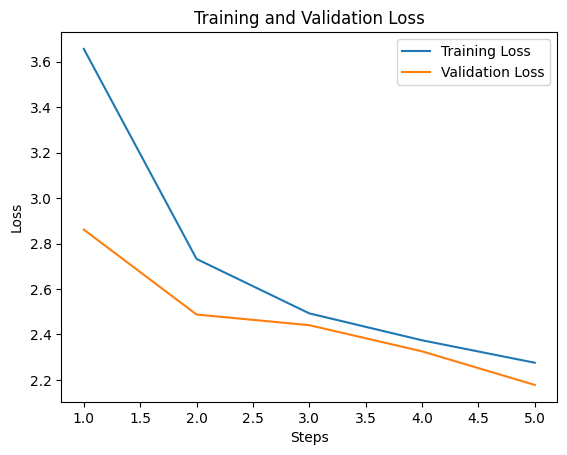

In [ ]:
from matplotlib.pylab import plt

# Generating a sequence of integers to represent the epoch numbers
steps = range(1, len(train_loss)+1)

plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

## Test Time!

In [ ]:
def inference(count=6, cols=3):
    images , captions = [], []

    model.eval()
    with torch.no_grad():
        for i in range(count):
            idx = np.random.randint(0, len(test_dataset))
            sample = test_dataset[idx]
            caption = model.predict(sample['image'].unsqueeze(0).to(device), max_len=15)
            images.append(sample['original'])
            captions.append(caption)

    show_sample(images, captions, cols=cols)

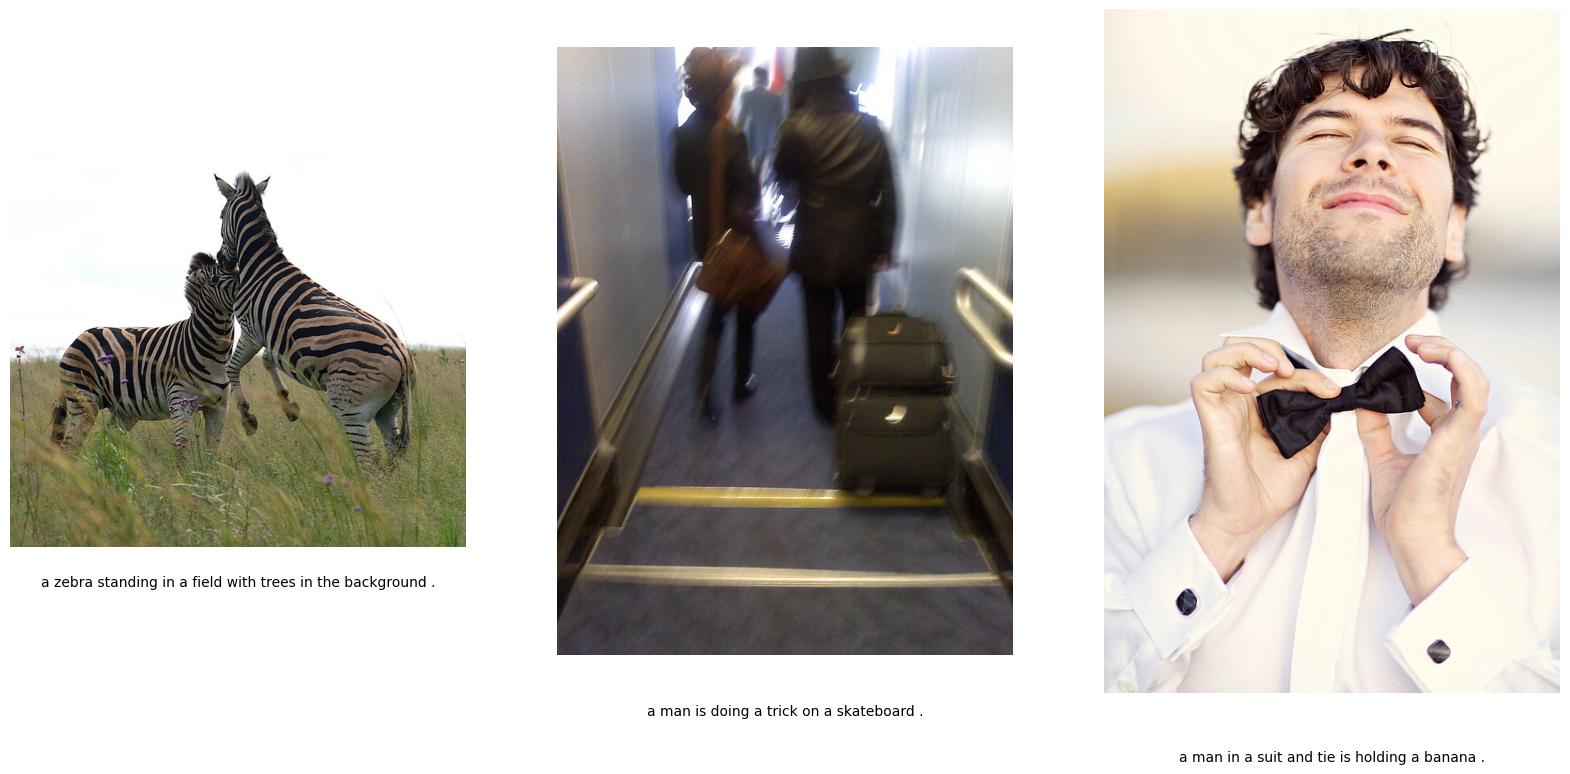

In [ ]:
inference(3)